# Nano GPT

Nano GPT implementation by Andrej Karpathy.

* [nanoGPT](https://github.com/karpathy/nanoGPT)
* [Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY)
* [nanogpt-lecture](https://github.com/karpathy/ng-video-lecture)


In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
%load_ext autoreload
%autoreload 2


import inspect
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from bigram import (
    V,
    B,
    T,
    C,
    get_batch,
)

# Data

Using tinyshakespeare as the dataset

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-01-02 12:05:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2024-01-02 12:05:24 (10.3 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



# Terminologies

* B: Batch size
* T: Time steps or Sequence length (e.g. 512 for bert input sequence)
* C: Channel or Feature (channel perhaps because Andrej is from CNN background?). ```C=2``` two features in each x.

## Batch Input

<img src="./image/gpt_batch.jpeg" align="left" width=750/>


## Bigram Language Model

The Bigram Language Model is **NOT using context of size T** but using the current token to predict next token, hence **Bi**gram. The objective of a Language Model is to use the historycal context, but here in the Bigram Model, Andrej is building very simple Markov Chain process to **generate next token only from the current token** for the sake of explaning the basic idea of token generation with bare naked possible way as he mentioned at [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2077) and [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2261).

> right now the history is not used, so it looks silly (but eventually history will be used). ...
> 
> Given the previous context of whatever generated, we only look at the very last character (```[:, -1, :]```) to make the prediciton of what comes next.

* [Let's build GPT: from scratch, in code, spelled out - simplest baseline](https://youtu.be/kCc8FmEb1nY?t=1383)

The ```idx:shape(B,T)``` is the idices to extract ```T``` number embedding vectors for the tokens. The ```token_embedding_table``` is e.g. a table of word embeddings in Word2Vec for each word in the vocabulary of the language. Andrej is using ```vocab_size``` as the dimension of the token embedding vector dimensions, hence the table has ```(number of words in language, dimensions)==(vocab_size, vocab_size)```. 

The reason using ```vocab_size``` as the dimensions is because Andrej simlifies the classification head which predicts the next token. Usually there is a **fully connected (FC)** layer that reduces the higher dimension down to N classes to predict, then apply softmax and argmax to select the hightest probability token index. Here, he skipped **FC** and directly generate N class outputs where ```N==vocab size``` so that the model can directly predict which word in the vocabulary to come next as GPT output.

<img src="./image/andrej_gpt_dev_idx.png" align="left" width=500/>

The ```generate``` function is the mechanism to continuously generate the next tokens from the given context (prompt). In this Bigram Language Model, the (last) token predicts the next token, hence take the last token embedding vector with ```[:, -1, :]``` to get the next token id via softmax and argmax (```torch.multinomial(, num_samples=1)```) as the next token.

<img src="./image/text_generation_from_prompt.png" align="left" width=500/>

This corresponds with GPT generates succeeding sentences given a prompt (context). 

* [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=1934)

By giving an index to one token as the first ```idx``` to the ```generate``` function, it will continuously generates ```max_new_tokens```.

```
# 0 as the index to the first token in the embedding table
first_token_index: int = torch.zeros((1, 1)  

# [0] to get first batch
first_batch = decode(m.generate(idx=first_token_index, dtype=torch.long), max_new_tokens=100)[0].tolist())  
print(first_batch)
```

<img src="./image/next_token_generation.jpeg" align="left" width=750/>

In [4]:
print(inspect.getsource(get_batch))

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


In [5]:
print(B,T,C)
x, y = get_batch('train')
x.shape

32 8 65


torch.Size([32, 8])

# Transformer

(The Transformer implementaion starting at [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2268))

Transformer generates a graph network between position-encoded tokens.

1. Get un-connected tokens as a sequence (e.g. sentence)
2. Wires connections among tokens by having looked at the co-occurrances of them in billions of sequences.


## Attention 

$$Attention(Q,K,V)=softmax(\frac {QK^T}{\sqrt {d_k}})$$


* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4301)
* [Building a GPT](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-)

> - Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
> - There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
> - Each example across batch dimension is of course processed completely independently and never "talk" to each other
> - In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
> - "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
> - "Scaled" attention additional divides `similarity` by ```1/sqrt(head_size)```. This makes it so when input Q,K are unit variance, `similarity` will be unit variance too and Softmax will stay diffuse and not saturate too much.
> 
> <img src="./image/transformer_attention_as_communication.png" align="left" width=250/>

## Dot Product

Transformer uses Scaled Dot Product Attention. Refresh the memory on what dot-product transformation does and where they are used.

* Similarity = Q@K
* Attention Valuye = Similarity@V

<img src="./image/transformer_self_attention_flow.jpeg" align="left"/>

## Q and K (Similarity Score)

For every token ```Q``` in a sequence, calculate the relation/communication with other token ```K``` in the sequence (for GPT, only previous tokens). This builds the graph network of Self Attention.


|Similarity Score (Q & K)| Proabability as Softmax |
|---|---|
|<img src="./image/transformer_dot_product_attention_similarity_score.jpeg" align="left" width=500/>|<img src="./image/transformer_dot_product_attention.png" align="left" width=175/>|



### Scale by $\sqrt{d_k}$

As in the name **Scaled** Dot-Product Attention, the similarity score is normalized by $\sqrt{d_k}$ to manage the variance.

* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4616)

> If you have unit gausian input of mean 0 and $W_K$ and $W_V$ are unit gaussian, and if you calculate the ```similarity``` naively, the variance is the order of the head size $d_k$ (e.g. approx 16 if $d_k$ == 16). By standardizing the ```similarity``` score by $\sqrt{d_k}$ the variance of the ```similarity``` socre will be normal (approx 1.0).

Otherwise, softmax will pickup the nodes with larger values, hence only specific nodes in the sequence will be incorporated into the BoW. We want to consider the communication among every nodes if there is, not specific ones only.

#### Without scaling

When the similarity score is not normalized/scaled by $\sqrt{d_k}$, the softmax becomes peaky like one hot encoding.

variance:14.592000007629395, softmax:tensor([7.8424e-03, 3.1967e-04, 3.8844e-02, 6.4541e-05, 9.5293e-01])


<StemContainer object of 3 artists>

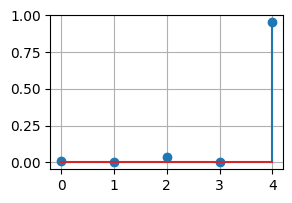

In [6]:
head_size = 16
naive_score = torch.tensor([0.1, -0.1, 0.2, -0.2, 0.4]) * head_size
# Note that variance is close to the head_size
print(f"variance:{naive_score.var()}, softmax:{torch.softmax(naive_score, dim=-1)}")

plt.figure(figsize=(3,2))
plt.grid()
plt.stem(range(len(naive_score)), torch.softmax(naive_score, dim=-1))

#### With scaling

By scale/normalize, the softmax will be smoothed/diffused.

variance:0.9120000004768372, softmax:tensor([0.1524, 0.0685, 0.2273, 0.0459, 0.5059])


<StemContainer object of 3 artists>

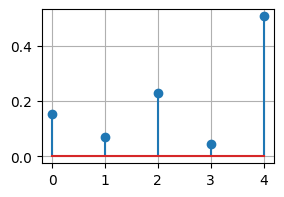

In [7]:
scaled_score = naive_score / torch.sqrt(torch.tensor(head_size))
print(f"variance:{scaled_score.var()}, softmax:{torch.softmax(scaled_score, dim=-1)}")

plt.figure(figsize=(3,2))
plt.grid()
plt.stem(range(len(scaled_score)), torch.softmax(scaled_score, dim=-1))

In [8]:
# let's see a single Head perform self-attention
torch.manual_seed(1337)

# B: batch size
# T: time steps or number of tokens to iterate or sequencee size
# C: channels or embedding vector dimension or features
B,T,C = 4,8,32 # batch, time, channels
head_size = 16
    
Wk = nn.Linear(C, head_size, bias=False)
Wq = nn.Linear(C, head_size, bias=False)

score2 = None
def calculate_similarity_score(x):
    k = Wk(x)   # (B, T, head_size)
    q = Wq(x)   # (B, T, head_size)

    # --------------------------------------------------------------------------------
    # Scaled Similarity between k and q as the first MatMul:
    # (B, T, head_size) @ (B, head_size, T) ---> (B, T, T)
    # same can be done with einsum ```score = torch.einsum("btd,bsd->bts", q, k)```.
    # score of each node is scaled by sqrt(head_size) so that the variance is approx 1.
    # --------------------------------------------------------------------------------
    score =  q @ k.transpose(-2, -1) / torch.sqrt(head_size, dim=-1)

    # --------------------------------------------------------------------------------
    # mask to make uni-direction (left to right only) for GPT.
    # For bi-directional e.g .BERT, skip the masking.
    # --------------------------------------------------------------------------------
    tril = torch.tril(torch.ones(T, T))
    score = score.masked_fill(tril == 0, float('-inf'))

    # --------------------------------------------------------------------------------
    # Normalize by softmax. exp(-inf) = 0 masks the score to make it uni-directional.
    # --------------------------------------------------------------------------------
    score = F.softmax(score, dim=-1)

    return score    # shape:(B, T, T)

## V (Bow/Bag of Words)

One way to generate the inter-connections among the tokens to distill their knowledges or relations is ```BoW``` by averaging them feature-wise/axis=-1.



<img src="./image/transformer_dot_product_attention_bow.png" align="left" width=700/>  

Note that the initially the value of similarity is random or ```(1.0, 1/2, 1/3, ...)``` but eventually it gets trained to memorize the relations among position-encoded tokens.

* [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=3814)

> Different will find other tokens more or less interesting and we want that data dependent. If I/token is a vowel, I am looking for consonants in my past and want to know what consonants were. And I want the information to flow to me (connection). This is the problem that Self Attention solves.

<img src="./image/self_attention.jpeg" align="left" width=700/>

### Purpose of  using $W_V$

$v$ looks to be a proxy of $x$ but what transformation or meaning does $W_V$ gives by having transformation from $x$ to $v$? (Note: ```x``` in the diagram above is actually $v$ as $v=x@W{_V}{^T}$).

* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4258)

> $x$ is like a private information to a token. For the purpose of the single attention head, $v$ is what I give for you to communicate with if you find me interesting.

In [9]:
Wv = nn.Linear(C, head_size, bias=False)

def calculate_attension_value(score, x):
    v = Wv(x)            # (B,T,C) @ (C,head_size) -> (B,T,head_size)
    value = score @ v    # (B,T,T) @ (B,T,head_size) -> (B,T,head_size)

    return value         # (B,T,head_size)

### Example A(Q,K,V)

In [10]:
x = torch.randn(B,T,C)

similarity_score = calculate_similarity_score(x)
similarity_score.shape

torch.Size([4, 8, 8])

In [11]:
attention_value = calculate_attension_value(similarity_score, x)
attention_value.shape

torch.Size([4, 8, 16])

## Multi Attention Head

Divide the embedding vector q, k, v into ```h``` number of segmenets and apply self attention to each segment in parallel respectively.

* <img src="./image/transformer_paper_multi_head_attention.png" align="left" width=700/>

* [Transformers Explained Visually (Part 3): Multi-head Attention, deep dive](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)

<img src="./image/transformer_multi_head_attention.png" align="left" width=500/>

## Pointwise Feed Forward

<img src="./image/transformer_paper_pointwise_feedforward.png" align="left" width=700/>